In [1]:
from pathlib import Path

In [2]:
# Environment setting functions
def _is_in_kaggle() -> bool:
    """Whether the current environment is in Kaggle."""
    return str(_dh[0]) == "/kaggle/working"


def _is_in_colab() -> bool:
    """Whether the current environment is in Colab."""
    return "google.colab" in str(get_ipython())


def _set_environment() -> str:
    """Set and print the environment."""
    if _is_in_kaggle():
        my_env = "in kaggle"
    elif _is_in_colab():
        my_env = "in colab"
    else:
        my_env = "in local"
    print(f"I'm {my_env}")

    return my_env


def set_base_directory() -> str:
    """Set and print the base directory."""
    my_env = _set_environment()
    if my_env == "in kaggle":
        base_dir = Path("/kaggle/input")
    elif my_env == "in colab":
        base_dir = Path("/content/data")
    else:
        base_dir = Path("../data")
    print(f"base_dir:{base_dir}")

    return base_dir

In [25]:
# Set directories
BASE_DIR = set_base_directory()

INPUT_DIR = BASE_DIR / "input"
INPUT_DIR = INPUT_DIR.resolve()

OUTPUT_DIR = BASE_DIR / "output"
OUTPUT_DIR = OUTPUT_DIR.resolve()
print(f"{INPUT_DIR, OUTPUT_DIR}")

I'm in local
base_dir:../data
(PosixPath('/home/chinchilla/src/github.com/chinchillaa/child-mind-institute/data/input'), PosixPath('/home/chinchilla/src/github.com/chinchillaa/child-mind-institute/data/output'))


# <p style="background-color:#6A1B9A; font-family:'Dancing Script', cursive; color:#FFFFFF; font-size:150%; text-align:center; border: 3px solid #FFEB3B; border-radius:40px; padding: 10px;">Child Mind Institute | SIngleLGBM</p>

In [4]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

/home/chinchilla/src/github.com/chinchillaa/child-mind-institute/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <p style="background-color:#6A1B9A; font-family:'Dancing Script', cursive; color:#FFFFFF; font-size:120%; text-align:center; border: 3px solid #FFEB3B; border-radius:40px; padding: 10px;">Basic Preprocess</p>

In [5]:
%%time


def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, "part-0.parquet"))
    df.drop("step", axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split("=")[1]


def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)

    with ThreadPoolExecutor() as executor:
        results = list(
            tqdm(
                executor.map(lambda fname: process_file(fname, dirname), ids),
                total=len(ids),
            )
        )

    stats, indexes = zip(*results)

    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df["id"] = indexes

    return df

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [6]:
train = pd.read_csv(f"{INPUT_DIR}/train.csv")
test = pd.read_csv(f"{INPUT_DIR}/test.csv")
sample = pd.read_csv(f"{INPUT_DIR}/sample_submission.csv")

In [7]:
train_ts = load_time_series(f"{INPUT_DIR}/series_train.parquet")
test_ts = load_time_series(f"{INPUT_DIR}/series_test.parquet")
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

  0%|          | 0/996 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 23.71it/s]


In [8]:
train = pd.merge(train, train_ts, how="left", on="id")
test = pd.merge(test, test_ts, how="left", on="id")

train = train.drop("id", axis=1)
test = test.drop("id", axis=1)

In [9]:
featuresCols = [
    "Basic_Demos-Enroll_Season",
    "Basic_Demos-Age",
    "Basic_Demos-Sex",
    "CGAS-Season",
    "CGAS-CGAS_Score",
    "Physical-Season",
    "Physical-BMI",
    "Physical-Height",
    "Physical-Weight",
    "Physical-Waist_Circumference",
    "Physical-Diastolic_BP",
    "Physical-HeartRate",
    "Physical-Systolic_BP",
    "Fitness_Endurance-Season",
    "Fitness_Endurance-Max_Stage",
    "Fitness_Endurance-Time_Mins",
    "Fitness_Endurance-Time_Sec",
    "FGC-Season",
    "FGC-FGC_CU",
    "FGC-FGC_CU_Zone",
    "FGC-FGC_GSND",
    "FGC-FGC_GSND_Zone",
    "FGC-FGC_GSD",
    "FGC-FGC_GSD_Zone",
    "FGC-FGC_PU",
    "FGC-FGC_PU_Zone",
    "FGC-FGC_SRL",
    "FGC-FGC_SRL_Zone",
    "FGC-FGC_SRR",
    "FGC-FGC_SRR_Zone",
    "FGC-FGC_TL",
    "FGC-FGC_TL_Zone",
    "BIA-Season",
    "BIA-BIA_Activity_Level_num",
    "BIA-BIA_BMC",
    "BIA-BIA_BMI",
    "BIA-BIA_BMR",
    "BIA-BIA_DEE",
    "BIA-BIA_ECW",
    "BIA-BIA_FFM",
    "BIA-BIA_FFMI",
    "BIA-BIA_FMI",
    "BIA-BIA_Fat",
    "BIA-BIA_Frame_num",
    "BIA-BIA_ICW",
    "BIA-BIA_LDM",
    "BIA-BIA_LST",
    "BIA-BIA_SMM",
    "BIA-BIA_TBW",
    "PAQ_A-Season",
    "PAQ_A-PAQ_A_Total",
    "PAQ_C-Season",
    "PAQ_C-PAQ_C_Total",
    "SDS-Season",
    "SDS-SDS_Total_Raw",
    "SDS-SDS_Total_T",
    "PreInt_EduHx-Season",
    "PreInt_EduHx-computerinternet_hoursday",
    "sii",
]

featuresCols += time_series_cols

In [10]:
train = train[featuresCols]
train = train.dropna(subset="sii")

cat_c = [
    "Basic_Demos-Enroll_Season",
    "CGAS-Season",
    "Physical-Season",
    "Fitness_Endurance-Season",
    "FGC-Season",
    "BIA-Season",
    "PAQ_A-Season",
    "PAQ_C-Season",
    "SDS-Season",
    "PreInt_EduHx-Season",
]

In [11]:
def update(df):
    for c in cat_c:
        df[c] = df[c].fillna("Missing")
        df[c] = df[c].astype("category")
    return df


train = update(train)
test = update(test)

In [12]:
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}


"""This Mapping Works Fine For me I also Check Each Values in Train and test Using Logic. There no Data Lekage."""

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)

    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

print(f"Train Shape : {train.shape} || Test Shape : {test.shape}")

Train Shape : (2736, 155) || Test Shape : (20, 154)


In [13]:
%%time

train.head()

CPU times: user 111 µs, sys: 16 µs, total: 127 µs
Wall time: 129 µs


,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Stat_0,Stat_1,Stat_2,Stat_3,Stat_4,Stat_5,Stat_6,Stat_7,Stat_8,Stat_9,Stat_10,Stat_11,Stat_12,Stat_13,Stat_14,Stat_15,Stat_16,Stat_17,Stat_18,Stat_19,Stat_20,Stat_21,Stat_22,Stat_23,Stat_24,Stat_25,Stat_26,Stat_27,Stat_28,Stat_29,Stat_30,Stat_31,Stat_32,Stat_33,Stat_34,Stat_35,Stat_36,Stat_37,Stat_38,Stat_39,Stat_40,Stat_41,Stat_42,Stat_43,Stat_44,Stat_45,Stat_46,Stat_47,Stat_48,Stat_49,Stat_50,Stat_51,Stat_52,Stat_53,Stat_54,Stat_55,Stat_56,Stat_57,Stat_58,Stat_59,Stat_60,Stat_61,Stat_62,Stat_63,Stat_64,Stat_65,Stat_66,Stat_67,Stat_68,Stat_69,Stat_70,Stat_71,Stat_72,Stat_73,Stat_74,Stat_75,Stat_76,Stat_77,Stat_78,Stat_79,Stat_80,Stat_81,Stat_82,Stat_83,Stat_84,Stat_85,Stat_86,Stat_87,Stat_88,Stat_89,Stat_90,Stat_91,Stat_92,Stat_93,Stat_94,Stat_95
0,0,5,0,0,51.0,0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,0,NaN,NaN,0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,9,0,1,NaN,0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,1,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,1,2.340,1,46.0,64.0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,10,1,2,71.0,0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,1,5.0,7.0,33.0,0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,1,38.0,54.0,1,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,9,0,2,71.0,1,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,2,6.0,9.0,37.0,1,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,0,NaN,3,2.451,2,31.0,45.0,2,0.0,1.0,43330.0,43330.0,43330.0,43330.0,43330.

In [14]:
%%time

test.head()

CPU times: user 115 µs, sys: 17 µs, total: 132 µs
Wall time: 134 µs


,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,Stat_0,Stat_1,Stat_2,Stat_3,Stat_4,Stat_5,Stat_6,Stat_7,Stat_8,Stat_9,Stat_10,Stat_11,Stat_12,Stat_13,Stat_14,Stat_15,Stat_16,Stat_17,Stat_18,Stat_19,Stat_20,Stat_21,Stat_22,Stat_23,Stat_24,Stat_25,Stat_26,Stat_27,Stat_28,Stat_29,Stat_30,Stat_31,Stat_32,Stat_33,Stat_34,Stat_35,Stat_36,Stat_37,Stat_38,Stat_39,Stat_40,Stat_41,Stat_42,Stat_43,Stat_44,Stat_45,Stat_46,Stat_47,Stat_48,Stat_49,Stat_50,Stat_51,Stat_52,Stat_53,Stat_54,Stat_55,Stat_56,Stat_57,Stat_58,Stat_59,Stat_60,Stat_61,Stat_62,Stat_63,Stat_64,Stat_65,Stat_66,Stat_67,Stat_68,Stat_69,Stat_70,Stat_71,Stat_72,Stat_73,Stat_74,Stat_75,Stat_76,Stat_77,Stat_78,Stat_79,Stat_80,Stat_81,Stat_82,Stat_83,Stat_84,Stat_85,Stat_86,Stat_87,Stat_88,Stat_89,Stat_90,Stat_91,Stat_92,Stat_93,Stat_94,Stat_95
0,0,5,0,0,51.0,0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,0,NaN,NaN,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,9,0,1,NaN,0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,1,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,1,2.340,1,46.0,64.0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,10,1,2,71.0,0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,1,5.0,7.0,33.0,0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,1,38.0,54.0,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,9,0,2,71.0,1,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,2,6.0,9.0,37.0,1,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,0,NaN,3,2.451,2,31.0,45.0,2,0.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43

In [15]:
train.to_parquet(f"{INPUT_DIR}/train_preprocessed.parquet")
test.to_parquet(f"{INPUT_DIR}/test_preprocessed.parquet")

# <p style="background-color:#6A1B9A; font-family:'Dancing Script', cursive; color:#FFFFFF; font-size:120%; text-align:center; border: 3px solid #FFEB3B; border-radius:40px; padding: 10px;">Modeling | Single LGBM</p>

In [16]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: chinchilla. Use `wandb login --relogin` to force relogin


True

In [17]:
%%time


def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")


def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(
        oof_non_rounded < thresholds[0],
        0,
        np.where(
            oof_non_rounded < thresholds[1],
            1,
            np.where(oof_non_rounded < thresholds[2], 2, 3),
        ),
    )


def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


In [18]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

def prepare_data(train, test):
    """
    Prepare the data for training.

    Args:
        train (DataFrame): The training data.
        test (DataFrame): The test data.

    Returns:
        X (DataFrame): The feature data.
        y (Series): The target data.
    """
    X = train.drop(["sii"], axis=1)
    y = train["sii"]
    return X, y

def train_fold(model_class, X_train, y_train, X_val, y_val):
    """
    単一のフォールドでモデルを訓練する。

    Args:
        model_class (object): 訓練するモデルのクラス。
        X_train (DataFrame): 訓練用の特徴量データ。
        y_train (Series): 訓練用のターゲットデータ。
        X_val (DataFrame): 検証用の特徴量データ。
        y_val (Series): 検証用のターゲットデータ。

    Returns:
        model (object): 訓練されたモデル。
        y_train_pred (Series): 訓練データの予測値。
        y_val_pred (Series): 検証データの予測値。
    """
    model = clone(model_class)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    return model, y_train_pred, y_val_pred

def evaluate_fold(y_train, y_train_pred, y_val, y_val_pred):
    """
    単一のフォールドでモデルの性能を評価する。

    Args:
        y_train (Series): 訓練用のターゲットデータ。
        y_train_pred (Series): 訓練データの予測値。
        y_val (Series): 検証用のターゲットデータ。
        y_val_pred (Series): 検証データの予測値。

    Returns:
        train_kappa (float): 訓練データのQWKスコア。
        val_kappa (float): 検証データのQWKスコア。
    """
    train_kappa = quadratic_weighted_kappa(
        y_train, y_train_pred.round(0).astype(int)
    )
    val_kappa = quadratic_weighted_kappa(
        y_val, y_val_pred.round(0).astype(int)
    )
    return train_kappa, val_kappa

def optimize_predictions(y, oof_non_rounded):
    """
    Optimize the predictions using the minimize function.

    Args:
        y (Series): The target data.
        oof_non_rounded (Series): The non-rounded predictions.

    Returns:
        KappaOPtimizer (object): The optimization result.
    """
    KappaOPtimizer = minimize(
        evaluate_predictions,
        x0=[0.5, 1.5, 2.5],
        args=(y, oof_non_rounded),
        method="Nelder-Mead",
    )
    return KappaOPtimizer


In [19]:
def _apply_thresholds(predictions, thresholds):
    """
    最適化された閾値を連続的な予測に適用して、離散的なクラスラベルを得る。

    Args:
        predictions (array-like): 連続的な予測値。
        thresholds (array-like): 適用する閾値。

    Returns:
        array-like: 離散的なクラスラベル。
    """
    return np.digitize(predictions, bins=np.sort(thresholds))

In [20]:
def train_model(model_class, train, test, sample, n_splits=5, seed=42):
    """
    ストラティファイドKフォールドクロスバリデーションを使用して機械学習モデルを訓練します。

    Args:
        model_class (object): 訓練するモデルのクラス。
        train (DataFrame): 訓練データ。
        test (DataFrame): テストデータ。
        sample (DataFrame): サンプル提出データ。
        n_splits (int, optional): クロスバリデーションのフォールド数。デフォルトは5。
        seed (int, optional): シャッフルのためのランダムシード。デフォルトは42。

    Returns:
        submission (DataFrame): 提出用データフレーム。
        models (list): 訓練されたモデルのリスト。
    """
    X, y = prepare_data(train, test)
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    oof_non_rounded = np.zeros(len(y), dtype=float)
    oof_rounded = np.zeros(len(y), dtype=int)
    test_preds = np.zeros((len(test), n_splits))

    # 訓練されたモデルを保存するリストを定義
    models = []
    train_scores = []
    val_scores = []

    for fold, (train_idx, val_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # このフォールドでモデルを訓練し、予測を取得
        model, y_train_pred, y_val_pred = train_fold(
            model_class, X_train, y_train, X_val, y_val
        )

        # モデルを保存
        models.append(model)

        # このフォールドの性能を評価
        train_kappa, val_kappa = evaluate_fold(
            y_train, y_train_pred, y_val, y_val_pred
        )
        train_scores.append(train_kappa)
        val_scores.append(val_kappa)

        # 予測を保存
        oof_non_rounded[val_idx] = y_val_pred
        oof_rounded[val_idx] = y_val_pred.round(0).astype(int)
        test_pred = model.predict(test)
        test_preds[:, fold] = test_pred

        print(f"Fold {fold+1}: Train Kappa={train_kappa}, Validation Kappa={val_kappa}")
        wandb.log(
            {"Fold": fold + 1, "Train QWK": train_kappa, "Validation QWK": val_kappa}
        )

    # 全体の性能を表示
    mean_train_kappa = np.mean(train_scores)
    mean_val_kappa = np.mean(val_scores)
    print(f"Mean Train Kappa: {mean_train_kappa}")
    print(f"Mean Validation Kappa: {mean_val_kappa}")

    # 予測を最適化
    KappaOptimizer = optimize_predictions(y, oof_non_rounded)
    best_thresholds = KappaOptimizer.x

    # フォールド間の予測を平均化
    test_preds_mean = test_preds.mean(axis=1)

    # 最適化された閾値を適用
    final_test_preds = _apply_thresholds(test_preds_mean, best_thresholds)

    # 提出用データフレームを作成
    submission = pd.DataFrame({"id": sample["id"], "sii": final_test_preds})

    return submission, models

In [21]:
import json

dir = "../configs/Params7.json"
Params = json.load(open(dir, "r"))
LGBM_Params = Params["lgbm_params"]

In [28]:
%%time
import datetime
import pickle


with wandb.init(
    project="cmi",
    config=LGBM_Params,
    name=f"{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}_experiment",
) as run:
    Light = lgb.LGBMRegressor(
        **LGBM_Params, random_state=SEED, verbose=-1, n_estimators=200
    )
    Submission, models = train_model(Light, train, test, sample)
    # モデルのリストオブジェクトを保存
    model_path = f"../models/models_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}.pkl"
    pickle.dump(models, open(model_path, "wb"))
    # WandBのArtifactにmodelsを保存
    artifact = wandb.Artifact(name="lgbm_models", type="models")
    artifact.add_file(model_path)
    run.log_artifact(artifact)

Fold 1: Train Kappa=0.8195063546532082, Validation Kappa=0.4061333646809887
Fold 2: Train Kappa=0.8269896011450354, Validation Kappa=0.43519640852974184
Fold 3: Train Kappa=0.8277797107693059, Validation Kappa=0.4317860180610602
Fold 4: Train Kappa=0.8336470640654048, Validation Kappa=0.37550178617464003
Fold 5: Train Kappa=0.8268387560145052, Validation Kappa=0.39844010013457387
Mean Train Kappa: 0.8269522973294918
Mean Validation Kappa: 0.40941153551620096


Fold,▁▃▅▆█
Train QWK,▁▅▅█▅
Validation QWK,▅██▁▄
Fold,5
Train QWK,0.82684
Validation QWK,0.39844


CPU times: user 17.6 s, sys: 179 ms, total: 17.8 s
Wall time: 6.96 s


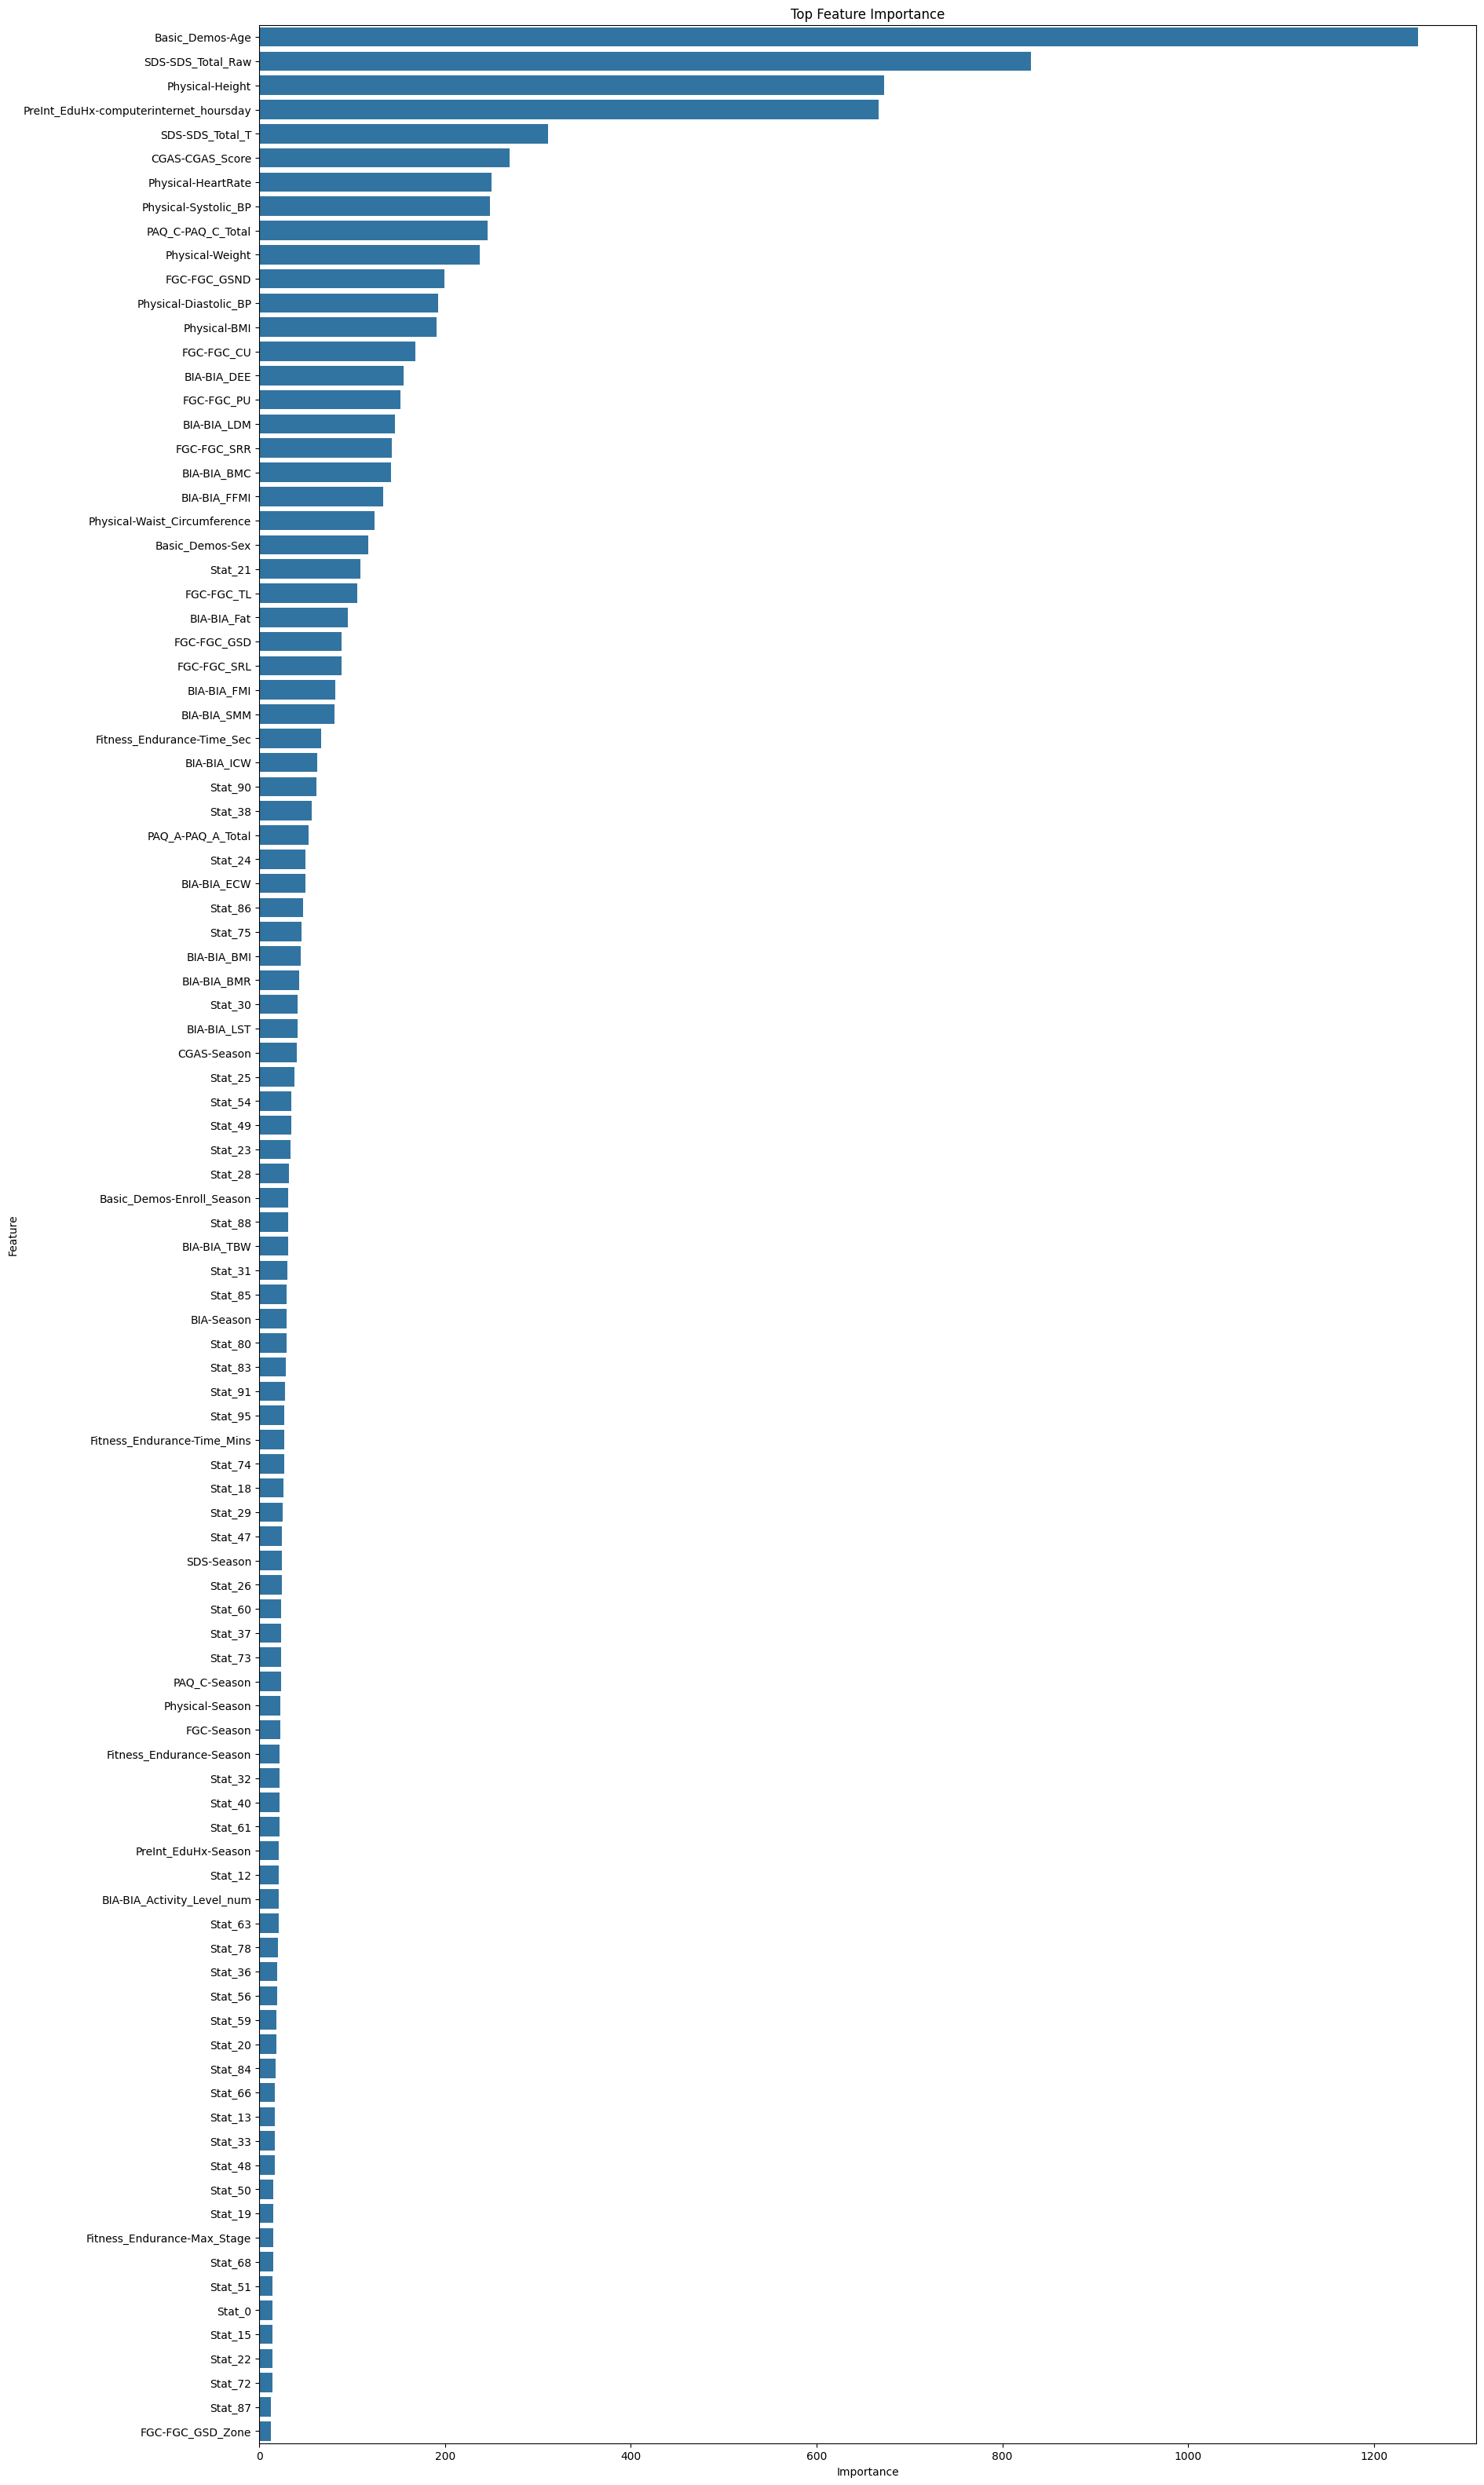

CPU times: user 809 ms, sys: 282 ms, total: 1.09 s
Wall time: 819 ms


In [32]:
%%time

# モデルの特徴量重要度を可視化
model = models[3]

feature_importance_df = pd.DataFrame(
    {
        "Feature": model.booster_.feature_name(),
        "Importance": model.booster_.feature_importance(importance_type="gain"),
    }
)

feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)

# 描画
plt.figure(figsize=(20, 40))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(100))
plt.title("Top Feature Importance")
plt.show()

# <p style="background-color:#6A1B9A; font-family:'Dancing Script', cursive; color:#FFFFFF; font-size:120%; text-align:center; border: 3px solid #FFEB3B; border-radius:40px; padding: 10px;">Submission</p>

In [34]:
%%time

Submission.to_csv(f"{OUTPUT_DIR}/submission.csv", index=False)
print(Submission)

          id  sii
0   00008ff9    1
1   000fd460    0
2   00105258    0
3   00115b9f    0
4   0016bb22    1
5   001f3379    1
6   0038ba98    0
7   0068a485    0
8   0069fbed    1
9   0083e397    1
10  0087dd65    0
11  00abe655    0
12  00ae59c9    2
13  00af6387    1
14  00bd4359    1
15  00c0cd71    2
16  00d56d4b    0
17  00d9913d    0
18  00e6167c    0
19  00ebc35d    1
CPU times: user 3.72 ms, sys: 93 µs, total: 3.81 ms
Wall time: 3.13 ms
